# ABOVE AC9 Data Processing  

## Checking Clean Water Blanks

**Authors:** Catherine Kuhn, Elena Terzić and Anna Simpson
**Last Updated:** August, 30th, 2018

### Import libraries

In [115]:
### Import the required python libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import glob
import os
import sys
import csv
from scipy import interpolate
from os import listdir
from os.path import isfile, join
import matplotlib.gridspec as gridspec

In [5]:
os.getcwd()

'/Users/Petrichor/Documents/FreshwatersOpticsToolkit/Code'

### Functions

#### Gets a list of the subdirectories in a target directory (default is listing subdirectories in the current directory)

In [20]:
def get_subdirectories(directory=os.getcwd()):
    if directory in os.getcwd():
        directories = os.listdir(os.getcwd())
    else:
        directories = os.listdir(directory)
    directories = [subdirectory for subdirectory in directories if not subdirectory.startswith('.')]
    return directories

#### Averages replicates from a list of file names (takes list of files, loads into panda as dataframe, then averages all the dataframes together)

In [7]:
def average_replicates(list_of_files):
    replicates = []
    for filename in list_of_files:
        replicates.append(pd.read_csv(filename, skiprows=0, delimiter = '\t'))
    x = replicates[0]
    for i in range(len(replicates)):
        # if it is the first file in the list of files, just go to the next one
        if i == 0:
            continue
        # if it is the second, third, etc, then add them together and average them
        else:
            x = x + replicates[i]
    # new file is x
    x = x/len(replicates)
    return x

#### Plots absorption/attenuation for multiple replicates

In [123]:
def plotting_absorption(list_of_files, title='Title'):
    j = 0
    x = []
    y = []
    labels_list = []
    for filename in range(len(list_of_files)):   
            df = pd.read_csv(list_of_files[filename], skiprows = 0, delimiter= '\t')         
            df.reset_index(inplace=True, drop=False)
            df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
            Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2= list_of_files[filename].split('/')[-1].split('.')[0].split('_')
            repname = 'Rep '+Rep
            labels_list.append(repname)
            plt.plot('wl','mean',data=df,label=repname)
            #plt.scatter('wl', 'a_mean', data = df)
            plt.errorbar('wl', 'mean', yerr='std', fmt='k-', linewidth=0.5, data = df) 
    plt.ylabel('a [1/m]')
    plt.title(title)
    plt.legend(labels_list)
    return plt

## Inputs

In [89]:
replicate_directory_name = '2_summary_stats'
averaged_files_name = '3_averaged_summary_stats'

replicate_files_location = os.path.abspath('..')+'/Data/'+replicate_directory_name
averaged_files_location = os.path.abspath('..')+'/Data/'+averaged_files_name

## Read and plot all files in a directory

In [90]:
## In the target directory, go through all the subdirectories. 
dict_of_files = {}
list_of_sampleids = []
for subdirectory in get_subdirectories(replicate_files_location):
    ### Get all the files in the subdirectory
    plotfiles = sorted(glob.glob(replicate_files_location+'/'+subdirectory+'/*.csv'))
    ## Create an empty dictionary in which to store filenames
    ## Iterate through all the file names in the directory
    for filename in plotfiles:
        #Get file info
        Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2= filename.split('/')[-1].split('.')[0].split('_')
        if 'cals' in subdirectory:
            if '_a_' in filename:
                unique_id = 'All_Calibrations_Absorption'
            if '_c_' in filename:
                unique_id = 'All_Calibrations_Attenuation'
        else:
            unique_id = '_'.join([Date, Site, Sample_Type, Abs_Type])
            if unique_id not in list_of_sampleids:
                list_of_sampleids.append(unique_id)
        if unique_id not in dict_of_files:
            dict_of_files[unique_id] = [filename]
        else:
            dict_of_files[unique_id].append(filename)

#### Put list of unique ids (Site, Date, Sample Type, and Analysis Type) into dictionary with key as combo of Site and Date, so all plots samples taken at the same site and date but of different sample types and analysis types can be compared in a grid

In [91]:
plotting_dict = {}
for i in list_of_sampleids:
    Date, Site, Type, Analysis = i.split('_')
    date_site = Date+'_'+Site
    if date_site not in plotting_dict:
        plotting_dict[date_site] = [i]
    else:
        plotting_dict[date_site].append(i)

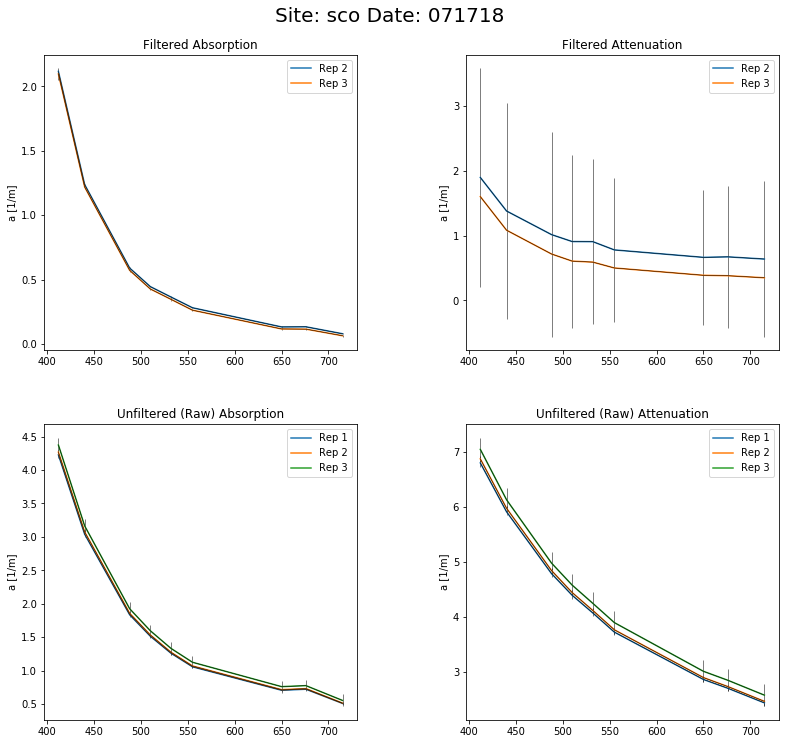

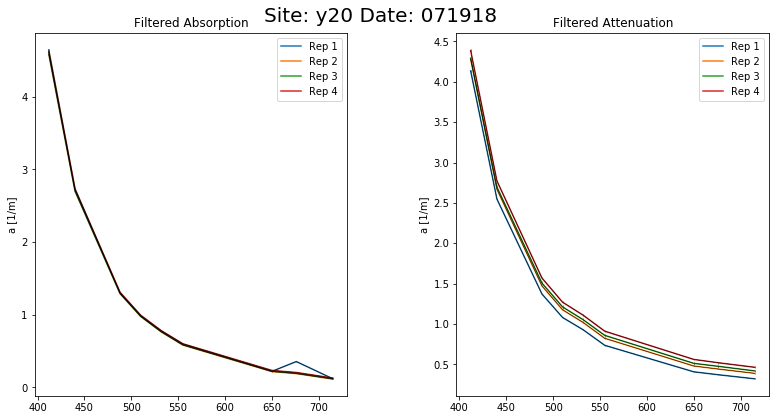

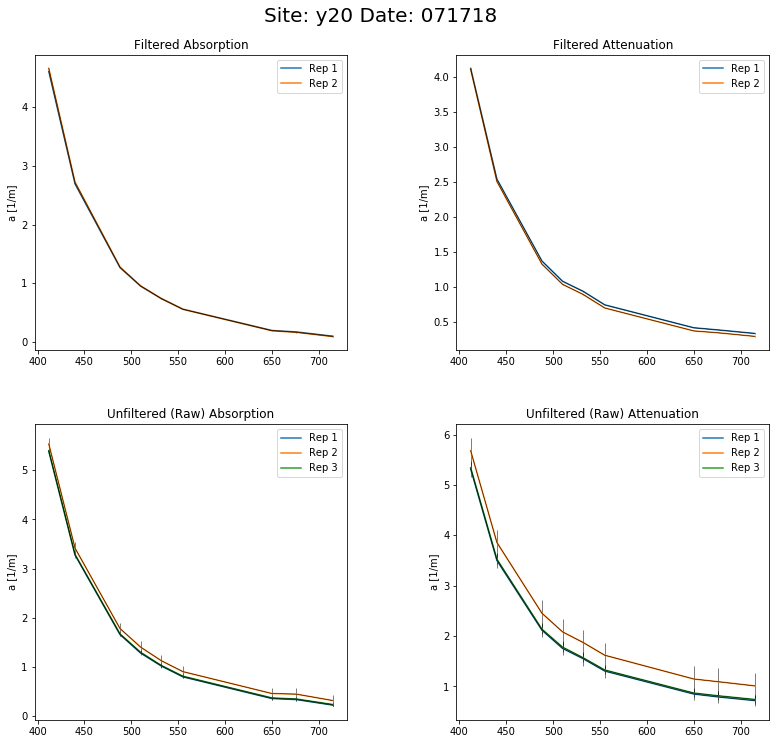

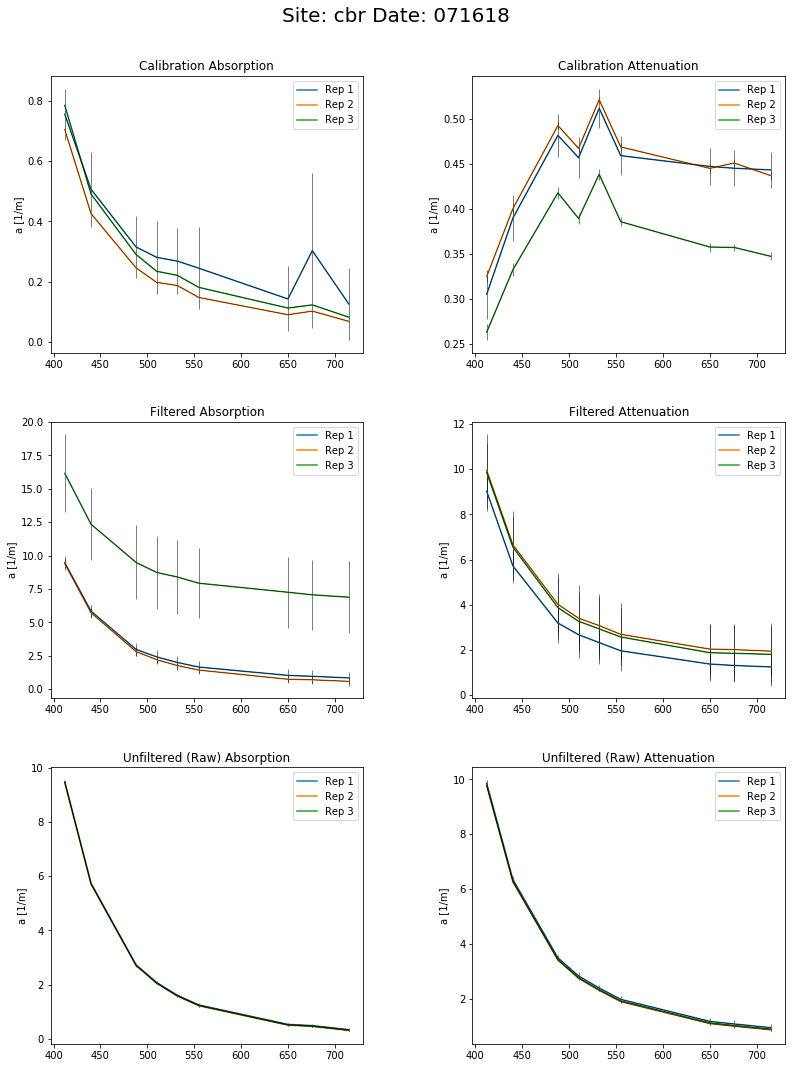

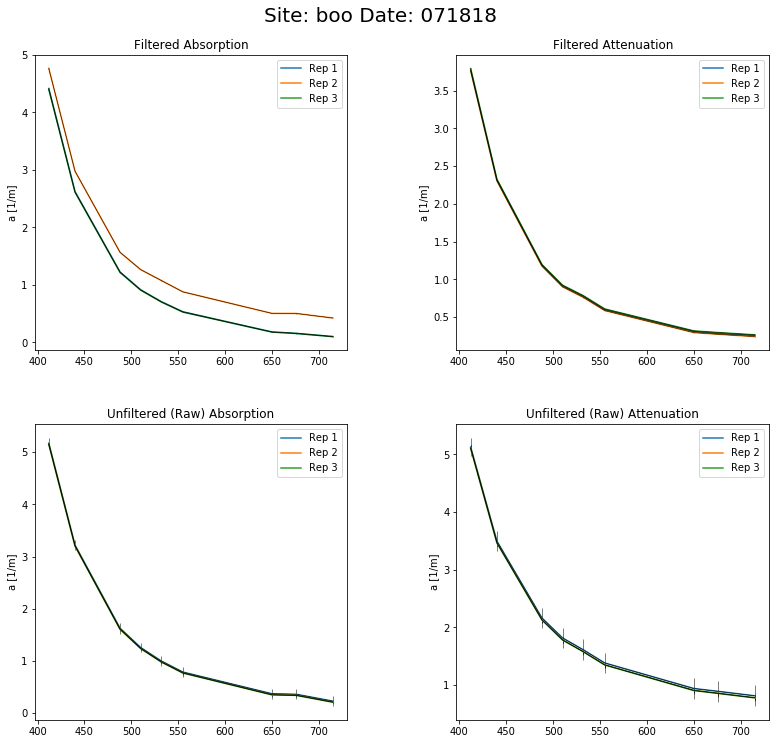

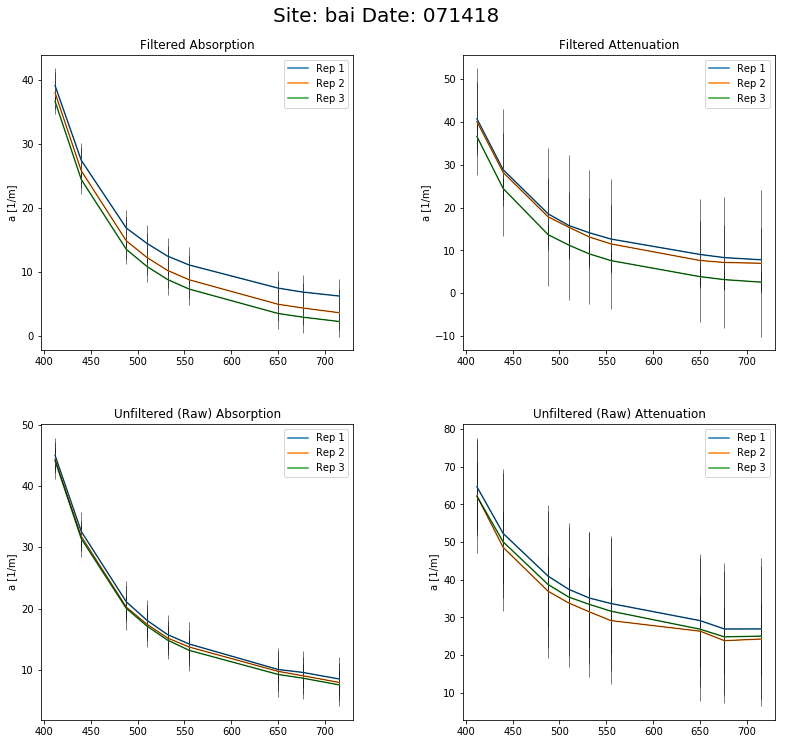

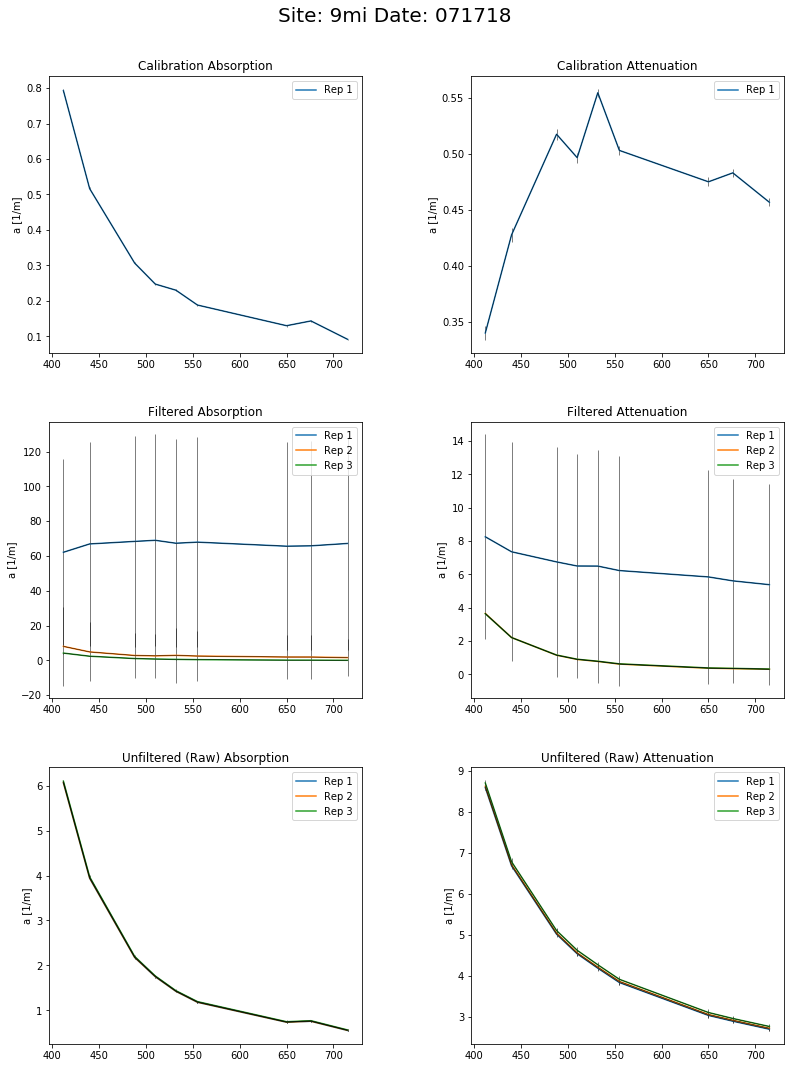

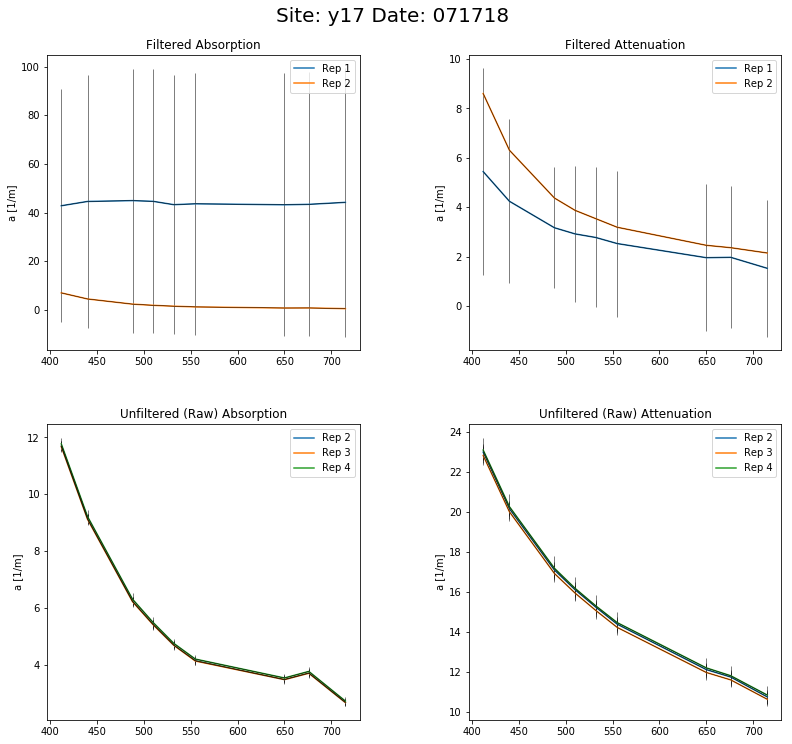

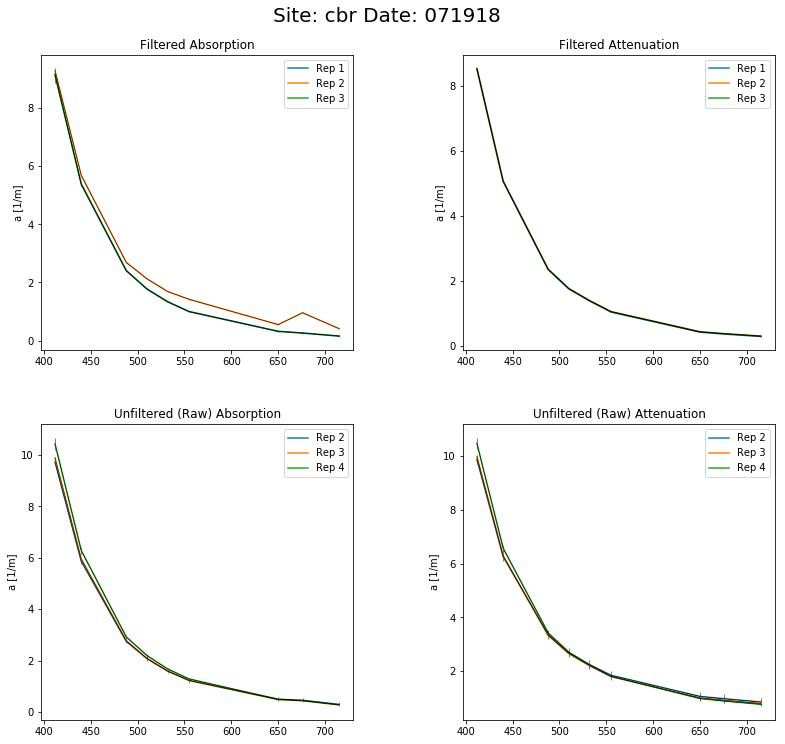

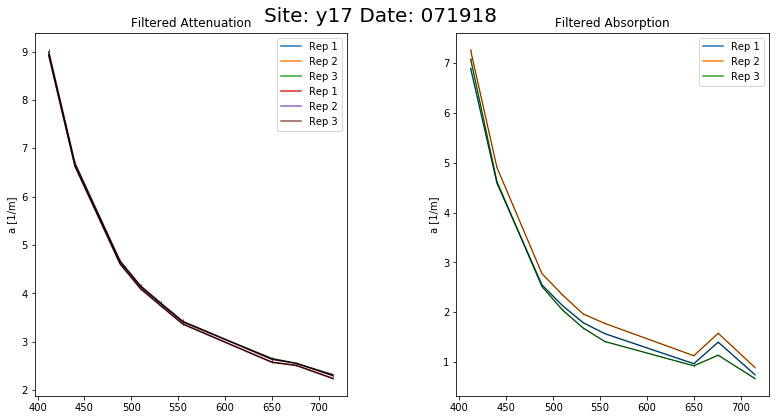

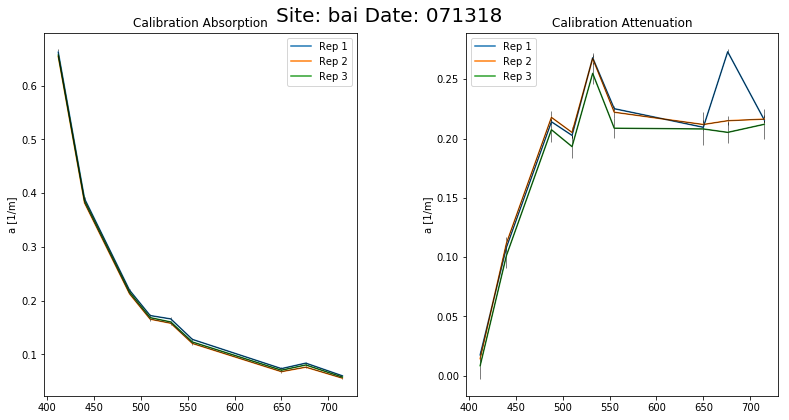

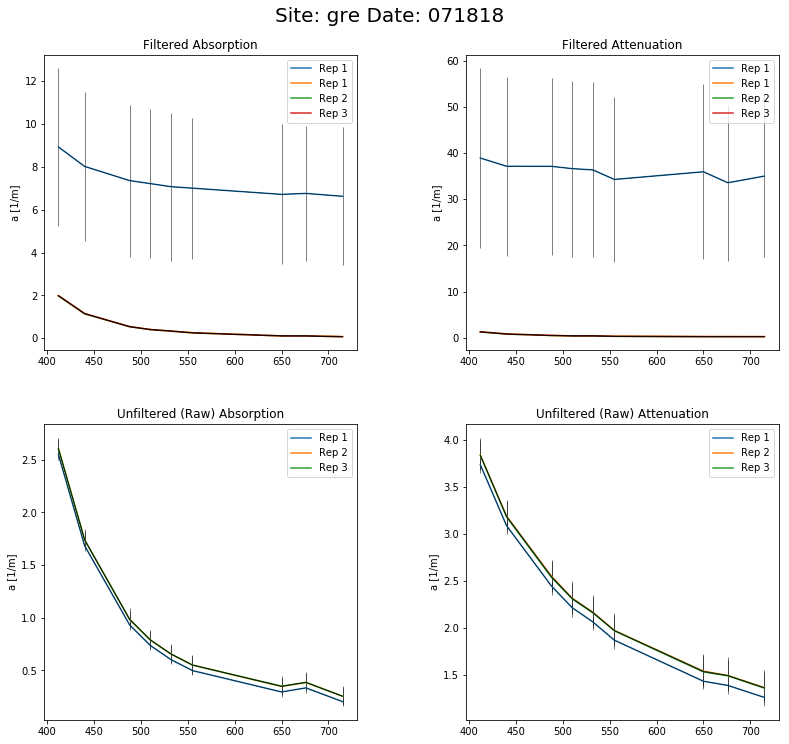

In [124]:
sample_types = {'fil':"Filtered",'raw':'Unfiltered (Raw)','cal':"Calibration"}
abs_types = {'a':'Absorption','c':'Attenuation'}

for i in plotting_dict:
    num_of_plots = len(plotting_dict[i])
    num_of_rows = num_of_plots/2
    count = 0
    Date_all, Site_all = i.split('_')
    plt.subplots(num_of_rows, 2, figsize=(12, 5*num_of_rows+1))
    for sampleid in plotting_dict[i]:
        count += 1
        Date, Site, Sample_Type, Abs_Type = sampleid.split('_')
        plottitle = ' '.join([sample_types[Sample_Type],abs_types[Abs_Type]])
        plt.subplot(num_of_rows, 2, count)    
        my_plot = plotting_absorption(dict_of_files[sampleid], title=plottitle)
        #dict_of_sampleids_and_plots[sampleid] = my_plot
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    my_plot.suptitle('Site: '+Site_all+' '+'Date: '+Date_all, fontsize=20)
    my_plot.show()

## Average replicates

In [92]:
## Make the new directory for averaged files to go into
if not os.path.exists(averaged_files_location):
    os.makedirs(averaged_files_location)

## Iterate through unique sample ids (combo of site, date, sample type (raw, etc), and analysis type (a or c))
## Sample ids are keys of dictionary made earlier; entries are lists of files that are replicates of that unique combo
for sampleid in dict_of_files:
    if 'All_Calibrations' in sampleid:
        averages_filename = sampleid + '_average.csv'
    else:
        Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2 = dict_of_files[sampleid][0].split('/')[-1].split('.')[0].split('_')
        averages_filename = '_'.join([Sensor, Date, Site, Sample_Type, Abs_Type,'average.csv'])
    averaged_file = average_replicates(dict_of_files[sampleid])
    outputdir = averaged_files_location + '/' + averages_filename
    averaged_file.to_csv(outputdir, sep='\t')   

## Plot average replicates

In [131]:
def create_dict_w_listentry(dictionary, key, entry):
    if key not in dictionary:
        dictionary[key] = [entry]
    else:
        dictionary[key].append(entry)

In [147]:
def plotting_absorption_2(list_of_files, title='Title'):
    j = 0
    x = []
    y = []
    labels_list = []
    for filename in range(len(list_of_files)):   
            df = pd.read_csv(list_of_files[filename], skiprows = 0, delimiter= '\t')         
            df.reset_index(inplace=True, drop=False)
            df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
            Sensor, Date, Site, Sample_Type, Abs_Type, eh= list_of_files[filename].split('/')[-1].split('.')[0].split('_')
            repname = 'Rep '+Rep
            date_site = Site+' '+Date
            labels_list.append(date_site)
            plt.plot('wl','mean',data=df,label=date_site)
            plt.scatter('wl', 'mean', data = df)
            plt.errorbar('wl', 'mean', yerr='std', fmt='k-', linewidth=0.5, data = df) 
    plt.ylabel('a [1/m]')
    plt.title(title)
    plt.legend(labels_list)
    return plt

In [137]:
dict_of_files = {}

for filename in sorted(glob.glob(averaged_files_location+'/*.csv')):
    #Get file info
    basename = filename.split('/')[-1].split('.')[0]
    if 'cal' in basename or 'Calibrations' in basename:
        continue
    else:
        Sensor, Date, Site, Sample_Type, Abs_Type, filetype= filename.split('/')[-1].split('.')[0].split('_')
        sampletype_abstype = Sample_Type+'_'+Abs_Type
        create_dict_w_listentry(dict_of_files, sampletype_abstype, filename)

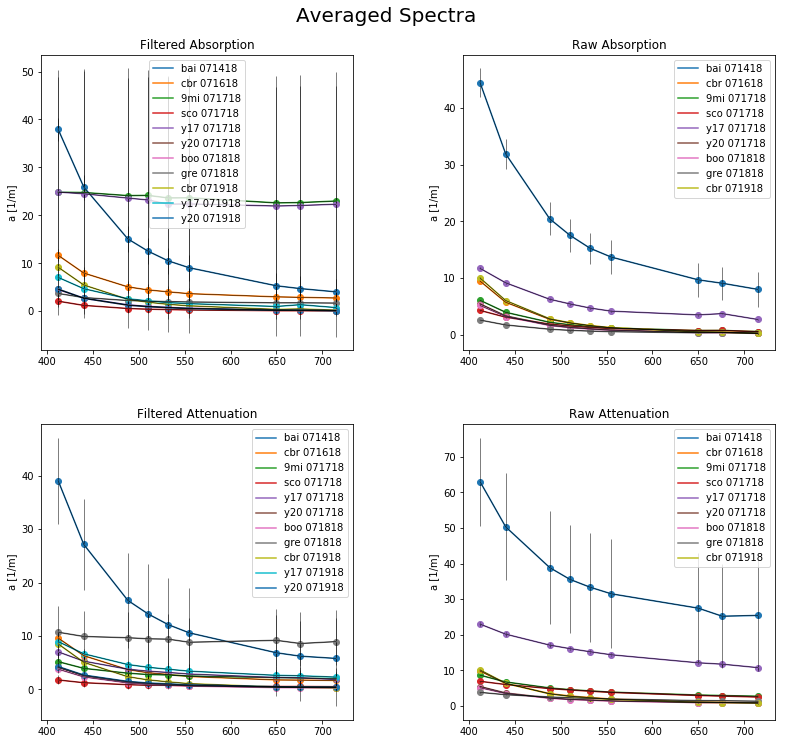

In [151]:
plt.subplots(2, 2, figsize=(12, 11))

plt.subplot(2, 2, 1)
plotting_absorption_2(dict_of_files['fil_a'], title='Filtered Absorption')

plt.subplot(2, 2, 2)
plotting_absorption_2(dict_of_files['raw_a'], title='Raw Absorption')

plt.subplot(2, 2, 3)
plotting_absorption_2(dict_of_files['fil_c'], title='Filtered Attenuation')

plt.subplot(2, 2, 4)
plotting_absorption_2(dict_of_files['raw_c'], title='Raw Attenuation')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
my_plot.suptitle('Averaged Spectra', fontsize=20)
my_plot.show()

In [ ]:


for i in plotting_dict:
    num_of_plots = len(plotting_dict[i])
    num_of_rows = num_of_plots/2
    count = 0
    Date_all, Site_all = i.split('_')
    plt.subplots(num_of_rows, 2, figsize=(12, 5*num_of_rows+1))
    for sampleid in plotting_dict[i]:
        count += 1
        Date, Site, Sample_Type, Abs_Type = sampleid.split('_')
        plottitle = ' '.join([sample_types[Sample_Type],abs_types[Abs_Type]])
        plt.subplot(num_of_rows, 2, count)    
        my_plot = plotting_absorption(dict_of_files[sampleid], title=plottitle)
        #dict_of_sampleids_and_plots[sampleid] = my_plot
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    my_plot.suptitle('Site: '+Site_all+' '+'Date: '+Date_all, fontsize=20)
    my_plot.show()

## Finding a statistic to check for significant differences between reps....hmm

In [46]:
mydf.to_csv('/Users/Petrichor/Desktop/stat_check.csv')

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean   
No. Observations: 27      Method:             REML   
No. Groups:       9       Scale:              0.0000 
Min. group size:  3       Likelihood:         54.3647
Max. group size:  3       Converged:          Yes    
Mean group size:  3.0                                
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept  1.157    0.389   2.971 0.003  0.394  1.920
Rep[T.2]  -0.011    0.001 -10.307 0.000 -0.013 -0.009
Rep[T.3]   0.012    0.001  11.155 0.000  0.010  0.014
Group Var  1.365  363.935                            



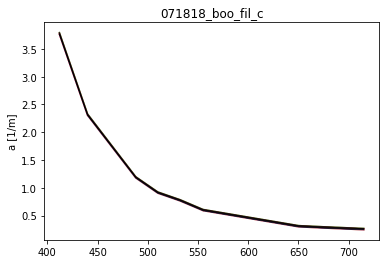

In [42]:
### Generate a dataframe including all reps, with a column denoting the reps
replicates = []
for filename in dict_of_files['071818_boo_fil_c']:
    Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2 = filename.split('/')[-1].split('.')[0].split('_')
    df = pd.read_csv(filename, skiprows=0, delimiter = '\t')
    df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
    df['Rep'] = str(Rep)
    #print df
    replicates.append(df)
mydf = pd.concat(replicates)
mydf['wl'].apply(str)
mydf

import statsmodels.api as sm
import statsmodels.formula.api as smf

data = mydf
md = smf.mixedlm("mean ~ Rep", data, groups=data["wl"])
mdf = md.fit()
print(mdf.summary())
plotting_absorption(dict_of_files['071818_boo_fil_c'], title='071818_boo_fil_c').show()

In [39]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

data = mydf
md = smf.mixedlm("mean ~ Rep", data, groups=data["wl"])
mdf = md.fit()
print(mdf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean   
No. Observations: 27      Method:             REML   
No. Groups:       9       Scale:              0.0000 
Min. group size:  3       Likelihood:         54.3647
Max. group size:  3       Converged:          Yes    
Mean group size:  3.0                                
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept  1.157    0.389   2.971 0.003  0.394  1.920
Rep[T.2]  -0.011    0.001 -10.307 0.000 -0.013 -0.009
Rep[T.3]   0.012    0.001  11.155 0.000  0.010  0.014
Group Var  1.365  363.935                            



In [31]:
for sampleid in dict_of_files:
    replicates = []
    for filename in dict_of_files[sampleid]:
        Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2 = filename.split('/')[-1].split('.')[0].split('_')
        df = pd.read_csv(filename, skiprows=0, delimiter = '\t')
        df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
        df['Rep'] = str(Rep)
        replicates.append(df)
    pd.concat(replicates)
    print replicates

[   Unnamed: 0     wl      mean       std  a_median     a_IQR Rep
0           0  412.0  0.591976  0.192675  0.617685  0.008013   1
1           1  440.0  0.346809  0.071495  0.356950  0.004217   1
2           2  488.0  0.188092  0.049426  0.194855  0.003827   1
3           3  510.0  0.143578  0.048618  0.150565  0.002998   1
4           4  532.0  0.137895  0.058832  0.146140  0.003405   1
5           5  555.0  0.103731  0.053839  0.111425  0.003502   1
6           6  650.0  0.053382  0.049377  0.061460  0.002745   1
7           7  676.0  0.065272  0.048239  0.073180  0.002865   1
8           8  715.0  0.036092  0.039795  0.041720  0.002842   1,    Unnamed: 0     wl      mean       std  a_median    a_IQR Rep
0           0  412.0  0.617012  0.004101   0.61732  0.00548   2
1           1  440.0  0.354836  0.002537   0.35480  0.00348   2
2           2  488.0  0.194446  0.002171   0.19426  0.00292   2
3           3  510.0  0.150545  0.001838   0.15040  0.00236   2
4           4  532.0  0.1459